# Ensembles 1: Random forests

## Learning objectives
- understand 
    - bootstrapping datasets
    - building ensembles by aggregating predictions
    - bagging
    - random forests
- implement
    - your first esemble
    - a random forests

## Intro - ensembles
### "The collective is smarter than the individual"


If we attempted to build an ensemble with multiple instances of the same model on the same dataset, this wouldn't help. 
Why?
Because they would all be identical (other than the differences induced by any stochastisity in the optimisation process).
This means that they would all make the same mistakes, and combining their predictions would not give any improvement.

### Why do ensembles work?
Mathematically, ensembles work because the mistakes made between models are not correlated.
This is because all of the errors are correlated.

To make sure the model errors are not correlated, we can't just train the same model on the same dataset, otherwise all of the errors would be the same for each model.
We can make the predictions differ (and uncorrelate the errors) in different ways, some of which we discuss below. 

### Bootstrapping datasets and bagging
The first way that we can make the models differ is by training them on different data.
We can "bootstrap" new datasets by sampling with replacement from the existing datasets.
Bootstrapping datasets to train different models on and aggregating their results is known as bootstrap aggregating or **bagging**.

Let's get our data and make some bootstrapped datasets

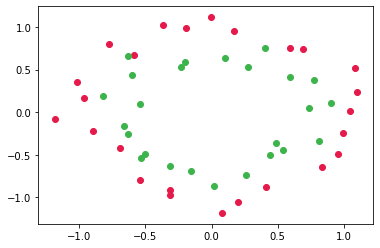

In [11]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn.datasets
from get_colors import colors
from utils import get_classification_data, show_data

# def get_data(sd=6, m=10, n_features=2, n_clusters=2):
#     X, Y = sklearn.datasets.make_blobs(n_samples=m, n_features=n_features, centers=n_clusters, cluster_std=sd)
#     return X, Y

def create_bootstrapped_dataset(existing_X, existing_Y, sample_weights=None):
    """Create a single bootstrapped dataset"""
    idxs = np.random.choice(np.arange(len(existing_X)), replace=True)
    return existing_X[idxs], existing_Y[idxs]

def create_bootstrapped_datasets(X, Y, n):
    """Create n bootstrapped datasets"""
    datasets = []
    for d in range(n):
        x, y = create_bootstrapped_dataset(X, Y)
        datasets.append((x, y))
    return datasets

X, Y = get_classification_data(m=50, variant='circles', noise=0.1, factor=0.7)
show_data(X, Y)
n_trees = 10
bootstrapped_datasets = create_bootstrapped_datasets(X, Y, n_trees)

## Let's firstly use a single decision tree to make predictions

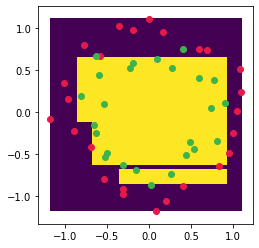

In [13]:
import sklearn.tree
from utils import visualise_predictions

tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(X, Y)
visualise_predictions(tree.predict, X)
show_data(X, Y)


## Random forests
Random forests are ensembles of decision trees (many trees make a forest).

### Learning on feature subsets
Another way that we can make the predictions differ, and further uncorrelate errors, is by only allowing the model to make predictions based on a limited number of the features. 
That is, we train each model on the features of examples from the dataset that have been projected into a subspace of the feature space.

To recap, the randomness in random forests is induced in two ways:
1. By training each tree on a random dataset, bootstrapped from the original
2. By having each tree project the data into a subspace of feature space before fitting it

## Implementation of random forest from scratch

Let's use the sklearn `DecisionTreeClassifier` as our model, and train an ensemble of them on different random subspaces of features to create a random forest.

In [14]:
def project_into_subspace(X, feature_idxs):
    return X[:, feature_idxs]

projected_X = project_into_subspace(X, [0])
print(projected_X)
print(X)

[[ 0.07607098]
 [-0.00056752]
 [-0.63064971]
 [-0.36492472]
 [-0.53192539]
 [ 0.81144824]
 [ 0.59033073]
 [-0.19834359]
 [-0.63498596]
 [ 0.53931252]
 [ 0.17030646]
 [ 0.69012577]
 [-0.77754167]
 [-1.02030865]
 [ 0.95618896]
 [ 0.20387164]
 [ 0.49098284]
 [ 0.83777895]
 [ 0.99608005]
 [ 0.40871249]
 [ 0.7403714 ]
 [-0.54427027]
 [-0.31484359]
 [ 1.08469551]
 [-0.1569693 ]
 [-0.22859113]
 [ 0.90674417]
 [ 0.27283935]
 [ 0.40421933]
 [-0.6898709 ]
 [ 0.09849332]
 [-0.31146388]
 [-0.31350148]
 [ 0.44342121]
 [ 0.77337815]
 [ 0.01801351]
 [-0.89936619]
 [ 1.04459634]
 [ 1.09867979]
 [-0.5422021 ]
 [-0.586759  ]
 [-0.81817667]
 [-0.50115006]
 [ 0.59040707]
 [-1.18447222]
 [-0.60456305]
 [-0.18984133]
 [-0.96760305]
 [ 0.26273257]
 [-0.66203863]]
[[ 0.07607098 -1.18153996]
 [-0.00056752  1.11283858]
 [-0.63064971  0.66505142]
 [-0.36492472  1.02553644]
 [-0.53192539 -0.53950118]
 [ 0.81144824 -0.34118826]
 [ 0.59033073  0.75171396]
 [-0.19834359  0.58736474]
 [-0.63498596 -0.25243832]
 [ 0.5

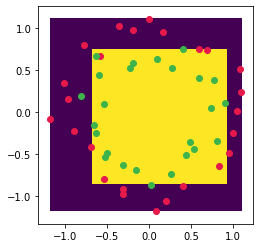

forest: [
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            1
        ]
    },
    {
        "depth": 2,
        "features": [
            0
        ]
    },
    {
        "depth": 2,
        "feature

In [28]:
import json

class RandomForest:
    def __init__(self, n_trees=10, max_depth=4):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, Y):
        for tree_idx in range(self.n_trees):
            n_features = np.random.choice(range(1, X.shape[1]))
            subspace_feature_indices = np.random.choice(range(X.shape[1]), size=n_features)
            projected_X = project_into_subspace(X, subspace_feature_indices)
            tree = sklearn.tree.DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(projected_X, Y)
            tree.feature_indices = subspace_feature_indices
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((len(X), self.n_trees)) # empty array of prediction with shape n_examples x n_trees
        for tree_idx, tree in enumerate(self.trees):
            x = project_into_subspace(X, tree.feature_indices)
            predictions[:, tree_idx] = tree.predict(x)#_proba(x)[:, 0]
        prediction = np.mean(predictions, axis=1)
        # prediction = prediction.astype(int)
        return prediction

    def __repr__(self):
        forest = []
        for idx, tree in enumerate(self.trees):
            forest.append({
                'depth': tree.max_depth,
                'features': tree.feature_indices.tolist()
            })
        return json.dumps(forest, indent=4)

randomForest = RandomForest(n_trees=20, max_depth=2)
randomForest.fit(X, Y)
randomForest.predict(X)
visualise_predictions(randomForest.predict, X)
show_data(X, Y)
print('forest:', randomForest)


## Sklearn implementation


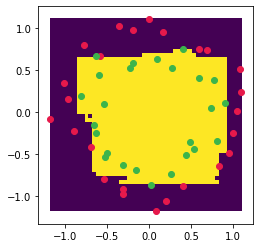

In [17]:
import sklearn.ensemble

randomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
randomForest.fit(X, Y)
visualise_predictions(randomForest.predict, X)
show_data(X, Y)

## Limitations of random forests
-

## Next steps
- Boosting
